# 필요 패키지 정의

In [1]:
# 필요한 라이브러리 임포트
import os
import io
from PIL import Image
import base64
from pathlib import Path
from langchain_core.documents import Document
import matplotlib.pyplot as plt
import pandas as pd
import torch
from getpass import getpass

# hwp 파일 로더
from llama_index.readers.file import HWPReader
from helper_hwp import hwp_to_txt, hwp_to_markdown, HwpDocument

# pdf 파일 로더
from langchain_community.document_loaders import PyMuPDFLoader
import fitz  # 텍스트 및 이미지 추출을 위한 라이브러리
import camelot  # 테이블 추출을 위한 라이브러리

# OCR
try:
    import pytesseract
    from paddleocr import PaddleOCR

    print("OCR is available")
    OCR_AVAILABLE = True
except Exception:
    print("OCR is not available")
    OCR_AVAILABLE = False

# OpenAI로 캡션 생성 (LangChain)
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

/home/public/public_venv/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


GITHUB_URL = https://github.com/c0z0c/helper_hwp


/home/public/public_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Checking connectivity to the model hosters, this may take a while. To bypass this check, set `DISABLE_MODEL_SOURCE_CHECK` to `True`.


OCR is available


# 한글 폰트 오류 로그 제거용

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)

fm.fontManager.addfont(path)

Reading package lists... Done


Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Font directories:
	/root/.local/share/fonts
	/usr/local/share/fonts
	/usr/share/fonts
	/root/.fonts
	/usr/share/fonts/cMap
	/usr/share/fonts/cmap
	/usr/share/fonts/truetype
	/usr/share/fonts/cmap/adobe-cns1
	/usr/share/fonts/cmap/adobe-gb1
	/usr/share/fonts/cmap/adobe-japan1
	/usr/share/fonts/cmap/adobe-japan2
	/usr/share/fonts/cmap/adobe-korea1
	/usr/share/fonts/truetype/dejavu
	/usr/share/fonts/truetype/liberation
	/usr/share/fonts/truetype/libreoffice
	/usr/share/fonts/truetype/nanum
	/usr/share/fonts/truetype/noto
/root/.local/share/fonts: skipping, no such directory
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching, new

# 데이터 경로 정의

In [3]:
DATA_DIR = Path("/home/public/data/raw_data")
n_samples = 1

# OpenAI API 키 입력

In [4]:
os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")

# 한글 파일 로더가 읽은 데이터 시각화

## 한글 파일만 리스트로 저장

In [5]:
hwp_docs = []
for fp in DATA_DIR.glob("**/*"):
    if fp.suffix.lower() in [".hwp"]:
        hwp_docs.append(fp)

In [6]:
len(hwp_docs)

96

## llama_index 로더 사용시 데이터 형식 확인

In [7]:
for i in range(n_samples):
    hwp_fp = hwp_docs[i]
    print(f"Processing file: {hwp_fp}")
    reader = HWPReader()
    docs = reader.load_data(file=hwp_fp)
    print(len(docs))
    print(docs)
    print(docs[0].text_resource.text)
    # for j, doc in enumerate(docs):
    #     print(f"--- Document {j} ---")
    #     print(doc.page_content)  # Print first 500 characters of the document
    #     print("\n")

Processing file: /home/public/data/raw_data/한국원자력연구원_한국원자력연구원 선량평가시스템 고도화.hwp
1
[Document(id_='a55c91f4-d51b-450b-950f-dc7582e0aa30', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='\x02捤獥\x00\x00\x00\x00\x02\x02汤捯\x00\x00\x00\x00\x02\x15湰灧\x00\x00\x00\x00\x15\x15桤灧\x00\x00\x00\x00\x15\x15桤灧\x00\x00\x00\x00\x15\x0b氠瑢\x00\x00\x00\x00\x0b\r\n1\r\n사업 안내\r\n\x15湯湷\x00\x00\x00\x00\x151.1 사업 개요\r\n가. 사업명 : 한국원자력연구원 선량평가시스템 고도화\r\n나. 사업 기간 : 계약일로부터 6개월\r\n다. 사업비 : 금 46,600 천원 (부가가치세 포함)\r\n라. 입찰방법 : 제한경쟁입찰\r\n○ 「소프트웨어산업진흥법 제24조의2 제2항」 및 「대기업인 소프트웨어 사업자가 참여할 수 있는 사업금액의 하한」에 따라 중소기업간 제한경쟁입찰\r\n마. 계약방법 : 협상에 의한 계약 (기술평가90%, 가격평가10%)\r\n○ 「국가를 당사자로 하는 계약에 관한 법률시행령 제43조(협상에 의한 계약체결) 및 제43조의2(지식기반사업의 계약방법)」에 의거 “협상에 의한 계약체결” 방법을 적용 \r\n1.2. 추진배경 및 필요성\r\n가. 규제요건 준수 필요\r\n○ 원

## helper_hwp 사용시 데이터 형식 확인

### hwp_to_txt, hwp_to_markdown 리턴 형식 확인

In [8]:
for i in range(n_samples):
    hwp_fp = hwp_docs[i]
    print(f"Processing file: {hwp_fp}")

    # Convert HWP to TXT
    txt_fp = hwp_to_txt(hwp_fp)
    print(f"Converted to TXT {i + 1}:\n{txt_fp}")

    md_fp = hwp_to_markdown(hwp_fp)
    print(f"Converted to Markdown {i + 1}:\n{md_fp}")

Processing file: /home/public/data/raw_data/한국원자력연구원_한국원자력연구원 선량평가시스템 고도화.hwp
Converted to TXT 1:
1
사업 안내
1.1 사업 개요
가. 사업명 : 한국원자력연구원 선량평가시스템 고도화
나. 사업 기간 : 계약일로부터 6개월
다. 사업비 : 금 46,600 천원 (부가가치세 포함)
라. 입찰방법 : 제한경쟁입찰
○ 「소프트웨어산업진흥법 제24조의2 제2항」 및 「대기업인 소프트웨어 사업자가 참여할 수 있는 사업금액의 하한」에 따라 중소기업간 제한경쟁입찰
마. 계약방법 : 협상에 의한 계약 (기술평가90%, 가격평가10%)
○ 「국가를 당사자로 하는 계약에 관한 법률시행령 제43조(협상에 의한 계약체결) 및 제43조의2(지식기반사업의 계약방법)」에 의거 “협상에 의한 계약체결” 방법을 적용
1.2. 추진배경 및 필요성
가. 규제요건 준수 필요
○ 원자력안전위원회고시 제2019-10호 ｢방사선방호 등에 관한 기준｣ 제16조(환경상의 위해방지)에서 제시하는 제한구역경계에서의 연간선량 준수 여부를 확인할 수 있는 체계 구축 필요
○ ICRP60 기반 평가장기 개선 필요
○ 액체유출물에 의한 주민피폭선량평가 수행 필요
나. 업무생산성 향상 필요
○ UI 개선을 통한 업무개선 및 신속한 의사결정 환경 구축 필요
○ 출력 기능 고도화를 통한 생산성 향상 필요
1.3. 사업 범위
가. 평가장기(Organ) 개선
○ 포트란 모듈 평가장기 개선
○ 웹시스템 평가장기 개선
나. 액체유출물에 의한 선량평가 기능 추가
○ 포트란 모듈 액체 선량평가 추가
○ 웹시스템 액체 선량평가 추가
1.4. 기대 효과
○ 정상운전 시 선량평가 관련 규제 수요에 대응
○ 선량평가 시스템 고도화를 통한 데이터 신뢰성 확보 및 생산성 향상
2
대상 업무 현황
2.1. 일반 현황
2.1.1. 설립 목적 및 근거
○ 설립 목적
- 원자력의 연구∙개발을 종합적

Converted to Markdown 1:
| 1 |
| --- |
|  |
| 사업 안내 |

### 1.1 사업 개요

가. 사업명 : 한국원자력연구원 선량평가시스템 고도화

나. 사업 기간 : 계약일로부터 6개월

다. 사업비 : 금 46,600 천원 (부가가치세 포함)

라. 입찰방법 : 제한경쟁입찰

○ 「소프트웨어산업진흥법 제24조의2 제2항」 및 「대기업인 소프트웨어 사업자가 참여할 수 있는 사업금액의 하한」에 따라 중소기업간 제한경쟁입찰

마. 계약방법 : 협상에 의한 계약 (기술평가90%, 가격평가10%)

○ 「국가를 당사자로 하는 계약에 관한 법률시행령 제43조(협상에 의한 계약체결) 및 제43조의2(지식기반사업의 계약방법)」에 의거 “협상에 의한 계약체결” 방법을 적용

### 1.2. 추진배경 및 필요성

가. 규제요건 준수 필요

○ 원자력안전위원회고시 제2019-10호 ｢방사선방호 등에 관한 기준｣ 제16조(환경상의 위해방지)에서 제시하는 제한구역경계에서의 연간선량 준수 여부를 확인할 수 있는 체계 구축 필요

○ ICRP60 기반 평가장기 개선 필요

○ 액체유출물에 의한 주민피폭선량평가 수행 필요

나. 업무생산성 향상 필요

○ UI 개선을 통한 업무개선 및 신속한 의사결정 환경 구축 필요

○ 출력 기능 고도화를 통한 생산성 향상 필요

### 1.3. 사업 범위

가. 평가장기(Organ) 개선

○ 포트란 모듈 평가장기 개선

○ 웹시스템 평가장기 개선

나. 액체유출물에 의한 선량평가 기능 추가

○ 포트란 모듈 액체 선량평가 추가

○ 웹시스템 액체 선량평가 추가

### 1.4. 기대 효과

○ 정상운전 시 선량평가 관련 규제 수요에 대응

○ 선량평가 시스템 고도화를 통한 데이터 신뢰성 확보 및 생산성 향상

| 2 |
| --- |
|  |
| 대상 업무 현황 |

### 2.1. 일반 현황

2.1.1. 설립 목적 및 근거

○ 설립 목적

- 원자력의 연구∙개발을 종합적으로 수행하여 학술의 진보, 에너지 확보

- 공통점
    - hwp_to_txt, hwp_to_markdown 함수는 이미지는 읽지 못함
    - 두 함수 모두 전체 문서를 하나의 텍스트로 읽어옴
- 차이점
    - hwp_to_txt는 테이블상에 존재하는 텍스트만 읽어오지만, hwp_to_markdown는 테이블의 구조를 마크다운형식으로 그대로 가져오는 것을 확인할 수 있었음

### HwpDocument 클래스 탐색

In [63]:
documents = HwpDocument(hwp_docs[0])
print(documents)
s = set()
for a in documents._iter_sequential():
    s.add(a[0].name)
    print(a[0].name)
print(s)

HwpDocument(file='/home/public/data/raw_data/한국원자력연구원_한국원자력연구원 선량평가시스템 고도화.hwp', version=5.0.3.4, sections=2)
PARAGRAPH
PICTURE
PICTURE
PAGE_NUM_POS
COMMENT
COMMENT
TABLE
PAGE_NUM_POS
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
COMMENT
NEW_NUMBER
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
TABLE
COMMENT
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
TABLE
PARAGRAPH
PICTURE
EQUATION
PARAGRAPH
TABLE
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
PARAGRAPH
TABLE
PARAGRAPH
PICTURE
PARAGRAP

In [ ]:
from helper_hwp.parsed_elements import ParsedTable

paragraphs = []
pictures: list[ParsedTable] = []
tables: list[ParsedTable] = []
for a in documents._iter_sequential():
    if a[0].name == "PARAGRAPH":
        paragraphs.append(a[1].text)
    elif a[0].name == "PICTURE":
        pictures.append(a[1])
    elif a[0].name == "TABLE":
        tables.append(a[1])
print(f"Number of paragraphs: {len(paragraphs)}")
print(f"Number of pictures: {len(pictures)}")
print(f"Number of tables: {len(tables)}")

print(f"paragraphs: {"\n".join(paragraph for paragraph in paragraphs)}")
print("pictures:")
for picture in pictures:
    print(picture.data)
print("tables:")
for table in tables:
    print(table.data)

Number of paragraphs: 2522
Number of pictures: 33
Number of tables: 87
paragraphs: 
1

사업 안내


1.1 사업 개요
가. 사업명 : 한국원자력연구원 선량평가시스템 고도화
나. 사업 기간 : 계약일로부터 6개월
다. 사업비 : 금 46,600 천원 (부가가치세 포함)
라. 입찰방법 : 제한경쟁입찰
○ 「소프트웨어산업진흥법 제24조의2 제2항」 및 「대기업인 소프트웨어 사업자가 참여할 수 있는 사업금액의 하한」에 따라 중소기업간 제한경쟁입찰
마. 계약방법 : 협상에 의한 계약 (기술평가90%, 가격평가10%)
○ 「국가를 당사자로 하는 계약에 관한 법률시행령 제43조(협상에 의한 계약체결) 및 제43조의2(지식기반사업의 계약방법)」에 의거 “협상에 의한 계약체결” 방법을 적용
1.2. 추진배경 및 필요성
가. 규제요건 준수 필요
○ 원자력안전위원회고시 제2019-10호 ｢방사선방호 등에 관한 기준｣ 제16조(환경상의 위해방지)에서 제시하는 제한구역경계에서의 연간선량 준수 여부를 확인할 수 있는 체계 구축 필요
○ ICRP60 기반 평가장기 개선 필요
○ 액체유출물에 의한 주민피폭선량평가 수행 필요
나. 업무생산성 향상 필요
○ UI 개선을 통한 업무개선 및 신속한 의사결정 환경 구축 필요
○ 출력 기능 고도화를 통한 생산성 향상 필요
1.3. 사업 범위
가. 평가장기(Organ) 개선
○ 포트란 모듈 평가장기 개선
○ 웹시스템 평가장기 개선
나. 액체유출물에 의한 선량평가 기능 추가
○ 포트란 모듈 액체 선량평가 추가
○ 웹시스템 액체 선량평가 추가
1.4. 기대 효과
○ 정상운전 시 선량평가 관련 규제 수요에 대응
○ 선량평가 시스템 고도화를 통한 데이터 신뢰성 확보 및 생산성 향상


2

대상 업무 현황

2.1. 일반 현황
2.1.1. 설립 목적 및 근거
○ 설립 목적
- 원자력의 연구∙개발을 종합적으로 수행하여 학술의 진보, 에너지 확보 및 원자력의 이용을 촉진하는데 기여
○ 설립 근

# PDF 파일 로더가 읽은 데이터 시각화

## pdf 파일만 리스트로 저장

In [11]:
pdf_docs = []
for fp in DATA_DIR.glob("**/*"):
    if fp.suffix.lower() in [".pdf"]:
        pdf_docs.append(fp)

In [12]:
len(pdf_docs)

4

## fitz 사용시 텍스트, 이미지 데이터 형식 확인

### 텍스트 데이터 확인

In [13]:
for i in range(n_samples):
    pdf_fp = pdf_docs[i]
    print(f"Processing file: {pdf_fp}")
    with fitz.open(pdf_fp) as doc:
        end = doc.page_count
        print(f"doc: {doc}")
        print(f"doc 메타데이터: {doc.metadata}")
        print(f"doc 페이지 수: {end}")
        for i in range(end):
            page = doc.load_page(i)
            text = page.get_text("text").strip()
            print(f"--- Page {i + 1} ---")
            print(text)
            if not text:
                continue

Processing file: /home/public/data/raw_data/고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf
doc: Document('/home/public/data/raw_data/고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf')
doc 메타데이터: {'format': 'PDF 1.7', 'title': '신규 콘텐츠 설명', 'author': '김미선', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Word Microsoft 365용', 'producer': 'Microsoft® Word Microsoft 365용', 'creationDate': "D:20240701105604+09'00'", 'modDate': "D:20240701105604+09'00'", 'trapped': '', 'encryption': None}
doc 페이지 수: 297
--- Page 1 ---
-1- 
 
 
 
제 안 요 청 서 
 
 
고려대학교  
차세대 포털·학사 정보시스템 구축 사업 
 
 
 
 
 
 
 
 
2024. 7. 01 
 
 
 
 
 
 
 
 
※ 본 자료는 제안내용의 설명을 위한 배포자료로, 이외 목적으로 무단복제, 전달 및 사용하는 행위를 금함.
--- Page 2 ---
-2- 
 
 
 
 
 
목   차   
Ⅰ. 사업개요 ··················································································································  4 
1. 사업 개요 ··············································································································  4 
2.

--- Page 36 ---
-36- 
 
 
 
 
 
3.  추진 체계 
 
가. 추진 조직도 
 
나. 조직별 역할 
구 분 
주요 역할 
차세대정보화추진단 
 차세대 정보화 정책 의사결정 
디지털전략팀 
 차세대 정보화 사업 총괄 
- 일정, 품질, 의사소통, 요구사항 관리, 변화관리, 위험요소 관리 
등 
- 요구사항 이행점검, 설계 및 기술 검토, 시스템 테스트, 데이터 
이관 검증, 산출물 검토 및 검수 
- 프레임워크, 개발표준 검토, 솔루션 기능 검토, H/W, S/W 성능
--- Page 37 ---
-37- 
 
 
 
 
 
검토, SI사로부터 기술 인수 
- 교육 및 지원 
정보화위원회 
 차세대 정보화 정책 심의·자문 
정보화실무위원회 
 차세대 정보화 사업 실무 자문 
사업수행사 
 사업 추진에 따른 계약의 이행 
감리수행사 
 차세대 정보화 사업 감리 수행
--- Page 38 ---
-38- 
 
 
 
 
 
Ⅳ   제안요청 내용 
 
 
1. 제안요청 개요 
❏ 공통사항 
❍ 본 내용은 본 사업과 관련된 모든 세부사업에 대하여 공통으로 적용함 
❍ 본 제안요청서의 요구사항 목록은 우리 대학이 필수로 요구하는 사항을 담고 있으며, 
본 사업의 목적을 충실히 달성하기 위해 요구사항 목록에서 제시하는 각 기능 요구 
외에도 현 정보시스템에서 유지되는 기능은 모두 구현되어야 함 
❍ 분석 단계의 요구사항 분석 결과에 따라 개발 볼륨은 조정될 수 있음 
❍ 차세대 시스템 구축에 따라 기존 시스템 중 어플리케이션 및 데이터 측면에서 
연계된 모든 시스템에 대한 연계 변경 관리가 되어야 함 
❍ 모든 제안 내용은 우리대학이 제시한 조건에 충족하여야 하며, 주사업자가 일괄 
제안하여야 함 
❍ 주사업자는 현 시스템의 운영현황, 본 사업의 추진목표 등을 파악하여 개발방법론, 
프로세스 등 최적의 개발방안을 제시하여야 함. 개발방안이라 함은 제시된 개발 기간 
동안 개발을 완료하는 것, 현업의 업무 적응력을 높이며 안정적으로 기술지원

### 이미지 데이터 확인

In [14]:
img_dir = Path("/home/public/data/processed/test_imgs")

Processing file: /home/public/data/raw_data/고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf
doc: Document('/home/public/data/raw_data/고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf')
doc 메타데이터: {'format': 'PDF 1.7', 'title': '신규 콘텐츠 설명', 'author': '김미선', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Word Microsoft 365용', 'producer': 'Microsoft® Word Microsoft 365용', 'creationDate': "D:20240701105604+09'00'", 'modDate': "D:20240701105604+09'00'", 'trapped': '', 'encryption': None}
doc 페이지 수: 297
page 17 layout: None
page 17 images: [(18, 0, 141, 40, 8, 'DeviceRGB', '', 'Image18', 'FlateDecode', 0), (101, 0, 538, 255, 8, 'DeviceRGB', '', 'Image101', 'DCTDecode', 0), (102, 0, 538, 255, 8, 'DeviceRGB', '', 'Image102', 'FlateDecode', 0)]
--- Image 1 ---
xref: 18
base: {'width': 141, 'height': 40, 'ext': 'png', 'colorspace': 3, 'xres': 96, 'yres': 96, 'bpc': 8, 'size': 7220, 'image': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x8d\x00\x00\x00(\x08\x02\x00

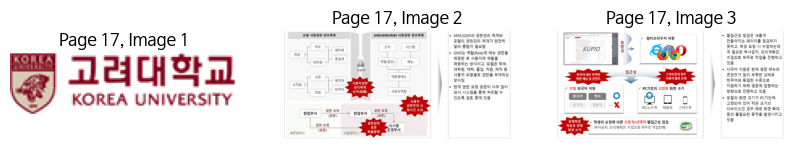

In [68]:
for i in range(n_samples):
    pdf_fp = pdf_docs[i]
    pdf_fp = Path(pdf_fp)
    print(f"Processing file: {pdf_fp}")
    with fitz.open(pdf_fp) as doc:
        end = doc.page_count
        print(f"doc: {doc}")
        print(f"doc 메타데이터: {doc.metadata}")
        print(f"doc 페이지 수: {end}")

        p = 16
        page = doc.load_page(p)

        layout = page.get_layout()  # 레이아웃 정보를 가져옴
        print(f"page {p+1} layout: {layout}")

        images = page.get_images(full=True)
        print(f"page {p+1} images: {images}")

        plt.figure(figsize=(10, 3))
        for j, img in enumerate(images):
            print(f"--- Image {j + 1} ---")
            xref = img[0]
            print(f"xref: {xref}")
            base = doc.extract_image(xref)
            print(f"base: {base}")
            img_bytes = base["image"]
            bbox = page.get_image_bbox(img)
            print(f"page {p+1}, image {j + 1} bbox: {bbox}")
            ext = base.get("ext", "png")
            img_file = img_dir / f"{pdf_fp.stem}_p{p+1}_img{j+1}.{ext}"
            img_file.parent.mkdir(parents=True, exist_ok=True)
            if not img_file.exists():
                img_file.write_bytes(img_bytes)
            # 이미지 시각화를 위한 코드
            plt.subplot(1, len(images), j + 1)
            plt.title(f"Page {p+1}, Image {j + 1}")
            plt.axis("off")
            plt.imshow(Image.open(io.BytesIO(img_bytes)))
            ext = base.get("ext", "png")
            print(f"ext: {ext}")

        plt.axis("off")
        plt.show()

### OCR 및 캡션 생성 확인

#### 읽어온 이미지 저장

In [16]:
img_list = []
for fp in img_dir.glob("**/*"):
    if fp.suffix.lower() in [".png", ".jpg", ".jpeg"]:
        img_list.append(fp)

#### OCR 실행 함수 정의 및 실행

/home/public/data/processed/test_imgs/고려대학교_차세대 포털·학사 정보시스템 구축사업_p17_img2.jpeg OCR result
eu 사용권한가        9104.05 Bae Bei
pth Gass        = ie
aa                 i     I
aga 888     a      액할업무:     oe
nen    =
개              3
zal   iE
Lge Hs         10199
wove 282% gunn 128

sons OB

ㆍ AMS/GMSSl BEE] Att
Bol 권한관리 제계가 온전히
wa Seo gow

+ GMS AB Relea ot BO
BS 후 사용자이 AER
Bete WHO BEE 학무.
cies, 재학. ge, 직원. 재직 동
사용자 SOME BOS FOIE
wae

+ 현재 ae 요정 80148 많이
와서 Awe 통리 sae =
있도록 UE 종이 있음



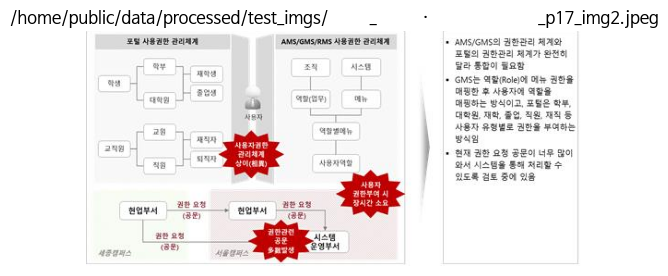

/home/public/data/processed/test_imgs/고려대학교_차세대 포털·학사 정보시스템 구축사업_p17_img3.png OCR result
+ auee sue NEA
은) sees 8              Bee aes
Beep
가 ane
apa avauae aes
버

 다국어 XIE 현재 Be 미뉴와
7                                               S827 많이 부족한 wae
20a 동일한 수준으로

+ poate a8 화원 a7,          Qooseueaae

ween ages 있음
&   Oo           + Bal me 크기가 %<기반에
교정되어 있어 작은 크기의
Kiem aun 0 205로        되바이스인 경우 매번 화면 wt
동의 풀월요한 Sue WEIS

' 학생의 요정에 의한 SAV HBOS 점검                                iad
cusiasnsesasancencen GSS



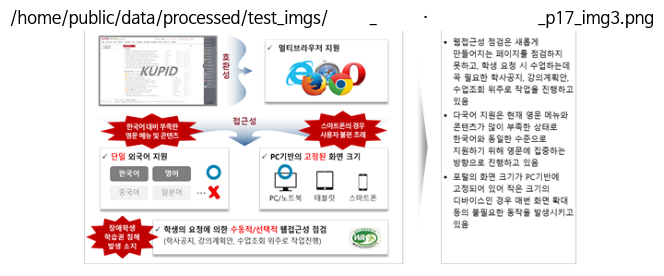

/home/public/data/processed/test_imgs/고려대학교_차세대 포털·학사 정보시스템 구축사업_p17_img1.png OCR result
고려대학교

KOREA UNIVERSITY



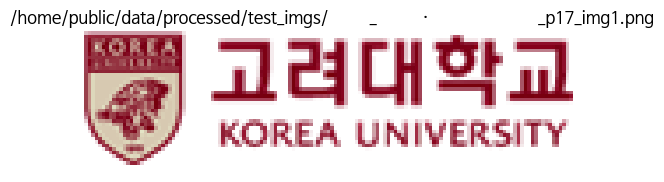

In [17]:
def _run_ocr(image_path: Path) -> str:
    """
    OCR을 실행하여 이미지에서 텍스트를 추출합니다.
    - image_path: 이미지 파일 경로
    - return: 추출된 텍스트
    """
    if not OCR_AVAILABLE:
        return ""
    img = Image.open(image_path).convert("RGB")
    txt = (pytesseract.image_to_string(img, lang="kor+eng") or "").strip()
    return txt if len(txt) >= 5 else ""


for img_path in img_list:
    print(f"{img_path} OCR result\n{_run_ocr(img_path)}\n")
    plt.title(f"{img_path}")
    plt.imshow(Image.open(img_path))
    plt.axis("off")
    plt.show()

- 이미지가 복잡하면 OCR 성능이 매우 안좋아지는 것을 확인할 수 있음
-> 강사님이 추천해주신 pytesseract가 아닌 paddleOCR 사용해보기

#### PaddleOCR

In [18]:
# ocr = PaddleOCR(
#     use_doc_orientation_classify=False,
#     use_doc_unwarping=False,
#     use_textline_orientation=False,
# )

#### 캡션 생성 함수 정의 및 실행

In [19]:
def _image_to_data_url(image_path: Path) -> str:
    """
    이미지를 base64 인코딩된 data URL로 변환합니다.
    - image_path: 이미지 파일 경로
    - return: data URL
    """
    ext = image_path.suffix.lower().lstrip(".") or "png"
    mime = "image/png" if ext in ["png"] else "image/jpeg"
    b64 = base64.b64encode(image_path.read_bytes()).decode("utf-8")
    return f"data:{mime};base64,{b64}"

In [20]:
def _run_openai_caption_ko(
    caption_prompt_ko: str, _openai: ChatOpenAI, image_path: Path
) -> str:
    """
    OpenAI를 사용하여 이미지에 대한 한국어 캡션을 생성합니다.
    - image_path: 이미지 파일 경로
    - return: 생성된 캡션
    """
    data_url = _image_to_data_url(image_path)

    # OpenAI 비전 입력: content blocks (text + image_url) :contentReference[oaicite:2]{index=2}
    msg = HumanMessage(
        content=[
            {"type": "text", "text": caption_prompt_ko},
            {"type": "image_url", "image_url": {"url": data_url}},
        ]
    )

    resp = _openai.invoke([msg])
    return (resp.content or "").strip()

/home/public/data/processed/test_imgs/고려대학교_차세대 포털·학사 정보시스템 구축사업_p17_img2.jpeg caption
도표는 포털(포털/AMS/GMS/RMS) 사용자권한 관리체계를 비교 요약합니다. 구성요소: 사용자유형(학생·교직원·재직자·퇴직자), 조직/시스템, 역할(업무)→메뉴 매핑, 현업부서↔시스템운영부서의 권한요청(공문) 흐름. 핵심 의미: 현행은 권한체계가 시스템별로 상이·중복되고 공문 기반 수작업이 많아 통합된 역할기반 권한관리와 메뉴부여, 업무·시스템 연계 자동화가 필요함.



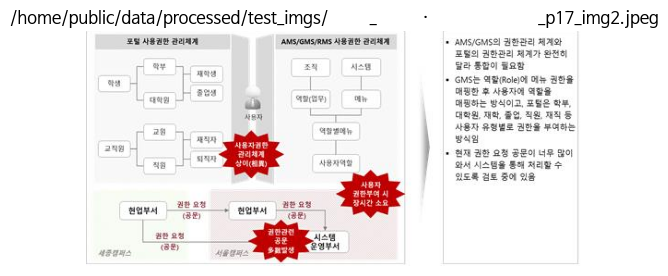

/home/public/data/processed/test_imgs/고려대학교_차세대 포털·학사 정보시스템 구축사업_p17_img3.png caption
그림은 교육플랫폼 KUPID의 호환성·접근성 이슈를 요약합니다. 핵심 구성요소: 1) 호환성(멀티브라우저 지원 필요) 2) 접근성(PC기반 고정 화면 크기 → 스마트폰 사용성 저하) 3) 다국어 지원 제한(한국어만, 중국어·일본어 미지원) 4) 장애학생 학습권 보장 및 필수 소지품 안내 5) 학생 요청 시 수동/선택적 접근성 점검(강의제작자·학사지원 개입). RFP에는 멀티브라우저·반응형 설계, 다국어 지원, 접근성 표준 준수 및 수동 점검 절차를 명시해야 함.



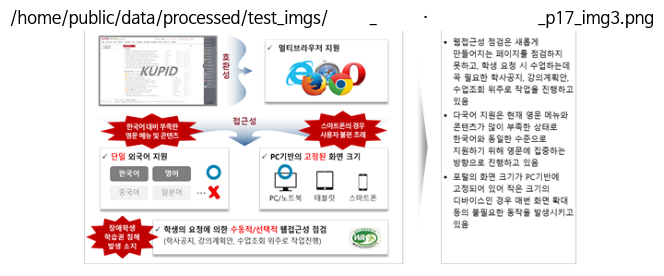

/home/public/data/processed/test_imgs/고려대학교_차세대 포털·학사 정보시스템 구축사업_p17_img1.png caption
첨부하신 이미지는 RFP 문서와 관련이 없는 로고/이미지로 판단됩니다. 요청하신 대로 RFP 분석에 도움이 되지 않는 그림은 설명하지 않겠습니다. RFP와 관련된 도표·표·흐름도·아키텍처 그림을 올려주시면 핵심 구성요소(항목/축/범례/단계)와 의미를 500자 이내로 정리해 드리겠습니다.



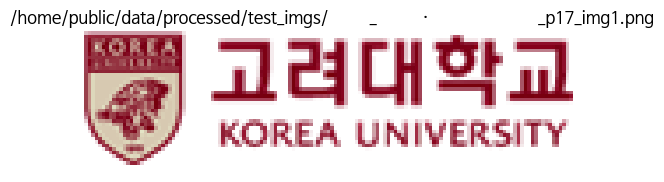

In [21]:
caption_prompt_ko: str = (
    "이 그림을 한국어로 500자 이내로 간단히 설명해 주세요."
    "도표/표/흐름도/아키텍처 그림이라면 핵심 구성요소(항목/축/범례/단계)와 의미를 요약해 주세요. "
    "RFP 문서 분석에 도움이 되도록 핵심 정보만 정리해 주세요."
    "RFP 문서와 관련이 없는 그림이라면 설명하지 마세요."
)
llm = ChatOpenAI(
    model="gpt-5-mini",
    temperature=0.0,
)
for img_path in img_list:
    print(
        f"{img_path} caption\n{_run_openai_caption_ko(caption_prompt_ko, llm, img_path)}\n"
    )
    plt.title(f"{img_path}")
    plt.imshow(Image.open(img_path))
    plt.axis("off")
    plt.show()

## camelot 사용시 테이블 데이터 형식 확인

- html, csv, markdown, json 등 다양한 형식의 파일로 테이블을 변환하는 것이 가능함
- Stream / Lattice / Network 파싱 방법이 존재
- **Stream**
    - PDF에 들어있는 텍스트의 좌표(bbox)를 보고, 행은 같은 y-라인에 모이는 텍스트, 열은 x-방향 간격(공백/정렬) 패턴으로 추정
- **Lattice**
    - 페이지를 이미지처럼 다루고(내부적으로 렌더링/처리), 셀을 구분하는 수평·수직 선(격자선) 을 검출해서 행/열 경계를 만듦
- **Network**
    - Lattice처럼 선을 찾는 게 아니라, PDF에 존재하는 텍스트 bbox들을 이용해 텍스트들의 정렬/연결(edge) 패턴을 “네트워크”로 보고 표의 몸통/헤더를 확장하며 찾는 텍스트 기반(table-like pattern) 접근

### stream 파싱 사용

In [22]:
for i in range(n_samples):
    pdf_fp = pdf_docs[i]
    tables = camelot.read_pdf(str(pdf_fp), pages="all", flavor="stream")
    print(f"Tables : {tables}")

Tables : <TableList n=308>


- camelot의 read_pdf 함수는 pdf 파일 내 모든 테이블을 읽어오기 때문에 실행 시간이 꽤 오래 걸리는 것을 확인
- 파일에서 308개의 테이블을 읽은 것을 확인

#### Table 데이터 탐색

In [23]:
for idx, t in enumerate(tables):
    print(f"------table {idx + 1}------")
    print(f"table: {t}")
    print(f"data: {t.data}")
    print(f"cols: {t.cols}")

------table 1------
table: <Table shape=(6, 1)>
data: [['제  안  요  청  서'], ['고려대학교'], ['차세대  포털·학사  정보시스템  구축  사업'], ['2024. 7. 01'], ['※  본  자료는  제안내용의  설명을  위한  배포자료로,  이외  목적으로  무단복제,  전달  및  사용하는  행위를  금함.'], ['-1-']]
cols: [(56.664, 540.9214034304)]
------table 2------
table: <Table shape=(25, 1)>
data: [['목      차'], ['Ⅰ.  사업개요 ··················································································································   4'], ['1.  사업  개요 ··············································································································   4'], ['2.  사업  배경 ··············································································································   4'], ['3.  사업  범위 ··············································································································   5'], ['4.  기대효과 ···············································································································   7'], ['Ⅱ.  현황  및  문제점 ···

#### 테이블 내용 마크다운으로 변환 후 확인

In [24]:
for idx, t in enumerate(tables):
    df: pd.DataFrame = t.df
    if df is None or df.empty:
        continue
    md = df.to_markdown(index=False)
    print(f"------table {idx + 1}------")
    print(md)

------table 1------
| 0                                                                                                                  |
|:-------------------------------------------------------------------------------------------------------------------|
| 제  안  요  청  서                                                                                                 |
| 고려대학교                                                                                                         |
| 차세대  포털·학사  정보시스템  구축  사업                                                                          |
| 2024. 7. 01                                                                                                        |
| ※  본  자료는  제안내용의  설명을  위한  배포자료로,  이외  목적으로  무단복제,  전달  및  사용하는  행위를  금함. |
| -1-                                                                                                                |
------table 2------
| 0                                                                        

------table 287------
| 0                                                                    |
|:---------------------------------------------------------------------|
| 등  서비스  이용  소외계층을  고려한  설계·구현을  검토하여야  한다. |
| 세부  기술  지침                                                     |
| o  웹브라우저  관련                                                  |
| - HTML 4.01/HTML 5, CSS 2.1                                          |
| - XHTML 1.0                                                          |
| - XML 1.0, XSL 1.0                                                   |
| 외부  접근                                                           |
| 장치                                                                 |
| - ECMAScript 3rd                                                     |
| -  한국형  웹  콘텐츠  접근성  지침  2.0                             |
| o  모바일  관련                                                      |
| -  모바일 웹 콘텐츠 저작 지침 1.0 (KICS.KO-10.0307)                  |
| 서비스                        

- stream 방식의 파싱 방법을 사용하면 모든 텍스트를 테이블로 인식하고 읽어들인다는 것을 확인할 수 있었음
- 테이블만 따로 추출하는 방식에는 부적합해보임

### lattice 파싱 사용

In [25]:
for i in range(n_samples):
    pdf_fp = pdf_docs[i]
    tables = camelot.read_pdf(str(pdf_fp), pages="all", flavor="lattice")
    print(f"Tables : {tables}")

Tables : <TableList n=385>


- 파일에서 385개의 테이블을 읽은 것을 확인

#### Table 데이터 탐색

In [26]:
for idx, t in enumerate(tables):
    print(f"------table {idx + 1}------")
    print(f"table: {t}")
    print(f"data: {t.data}")
    print(f"cols: {t.cols}")

------table 1------
table: <Table shape=(4, 3)>
data: [['정보시스템', '주요내용', '비고'], ['포털시스템', '\xad 통합로그인,  통합/지능형  검색,  마이페이지,  공지/알림,  일정관리, \n커뮤니티,  게시판,  사용자별  정보서비스,  위젯,  연계서비스(웹메일, \n챗봇,  전자결재,  학사/행정  서비스)  등 \n\xad 학생(졸업생포함),  교직원,  연구원  등  내부  구성원  대상  포털 \n\xad 학생/교수  등  신분별개인별  주요  정보  제공 \n\xad 학사/행정/연구  시스템의  주요  기능  직접  접근 \n\xad 위젯  등  개인화-SSO(기존  보유,  활용),  간편인증, 2차인증적용 \n\xad 사용자  통합관리-포털,  홈페이지,  교내  정보시스템의  웹  페이지 \n및  메뉴,  첨부  문서  검색 \n\xad 검색자의  신분에  맞는  검색  우선  노출 \n\xad 각  시스템  메뉴(화면)  색인을  통한  검색  및  시스템  접근  연계 \n\xad 사용자  입력  검색어와  검색  결과의  유사도  /  검색  결과  추천', '개인화 \n서비스'], ['모바일서비스', '\xad 통합로그인,  통합/지능형  검색,  마이페이지,  공지/알림,  일정관리, \n대학정보,  공간/기기  예약,  맞춤/추천정보,  학사정보,  행정정보  등 \n\xad 모바일  포털  앱은  기존  보유  앱(호잇)을  하이브리드  방식으로  재\n구축  +  일부  서비스  변경  (추가/삭제) \n\xad 모바일  웹  포털 \n\xad 푸쉬(알람)  기능', '기존  호잇 \n통합, \n하이브리드'], ['학사행정시스템', '\xad 기준정보  관리,  권한관리,  사용자  관리  등  공통  관리 \n\xad 학적,  교과,  수업,  성적,  졸업,  교직,  등록,  장학,  병무,  보건/공제, \n국제어학원 \n\xad 학생  데이터  통합 \n\xa

#### 테이블 내용 마크다운으로 변환 후 확인

In [27]:
for idx, t in enumerate(tables):
    df: pd.DataFrame = t.df
    if df is None or df.empty:
        continue
    md = df.to_markdown(index=False)
    print(f"------table {idx + 1}------")
    print(md)

------table 1------
| 0              | 1                                                                            | 2           |
|:---------------|:-----------------------------------------------------------------------------|:------------|
| 정보시스템     | 주요내용                                                                     | 비고        |
| 포털시스템     | ­ 통합로그인,  통합/지능형  검색,  마이페이지,  공지/알림,  일정관리,        | 개인화      |
|                | 커뮤니티,  게시판,  사용자별  정보서비스,  위젯,  연계서비스(웹메일,         | 서비스      |
|                | 챗봇,  전자결재,  학사/행정  서비스)  등                                     |             |
|                | ­ 학생(졸업생포함),  교직원,  연구원  등  내부  구성원  대상  포털           |             |
|                | ­ 학생/교수  등  신분별개인별  주요  정보  제공                              |             |
|                | ­ 학사/행정/연구  시스템의  주요  기능  직접  접근                           |             |
|                | ­ 위젯  등  개인화-SSO(기존  보유,  활용),  간편인증, 2차인증적용            |             |
|                | ­ 사용자  

- 마크다운으로 변환한 내용을 확인해보니 lattice 방식은 실제로 테이블 형태의 데이터가 아니면 읽어오지 않거나 빈 테이블을 읽음
- 빈 테이블의 경우 이미지나 텍스트 입력, 서류 양식을 위한 하나의 테이블 블록을 읽으면 빈 테이블이 됨
- 셀을 구분하는 격자선을 검출해서 행, 열 경계를 만드는 매커니즘 때문에 복잡한 표 레이아웃이 반영된 형태로 마크다운으로 변환됨
- 빈 테이블은 제거하는 방법이 필요해보임

### network 파싱 사용

In [28]:
for i in range(n_samples):
    pdf_fp = pdf_docs[i]
    tables = camelot.read_pdf(str(pdf_fp), pages="all", flavor="network")
    print(f"Tables : {tables}")

Tables : <TableList n=72>


- 파일에서 72개의 테이블을 읽은 것을 확인

#### Table 데이터 탐색

In [29]:
for idx, t in enumerate(tables):
    print(f"------table {idx + 1}------")
    print(f"table: {t}")
    print(f"data: {t.data}")
    print(f"cols: {t.cols}")

------table 1------
table: <Table shape=(32, 3)>
data: [['.  사업  범위', '', ''], ['가.  응용SW개발', '', ''], ['', '고려대학교  차세대  포털·학사  정보시스템  구축  사업', ''], ['정보시스템', '주요내용', '비고'], ['', '\xad 통합로그인,  통합/지능형  검색,  마이페이지,  공지/알림,  일정관리,', ''], ['', '커뮤니티,  게시판,  사용자별  정보서비스,  위젯,  연계서비스(웹메일,', ''], ['', '챗봇,  전자결재,  학사/행정  서비스)  등', ''], ['', '\xad 학생(졸업생포함),  교직원,  연구원  등  내부  구성원  대상  포털', ''], ['', '\xad 학생/교수  등  신분별개인별  주요  정보  제공', ''], ['', '\xad 학사/행정/연구  시스템의  주요  기능  직접  접근', '개인화'], ['포털시스템', '', ''], ['', '\xad 위젯  등  개인화-SSO(기존  보유,  활용),  간편인증, 2차인증적용', '서비스'], ['', '\xad 사용자  통합관리-포털,  홈페이지,  교내  정보시스템의  웹  페이지', ''], ['', '및  메뉴,  첨부  문서  검색', ''], ['', '\xad 검색자의  신분에  맞는  검색  우선  노출', ''], ['', '\xad 각  시스템  메뉴(화면)  색인을  통한  검색  및  시스템  접근  연계', ''], ['', '\xad 사용자  입력  검색어와  검색  결과의  유사도  /  검색  결과  추천', ''], ['', '\xad 통합로그인,  통합/지능형  검색,  마이페이지,  공지/알림,  일정관리,', ''], ['', '대학정보,  공간/기기  예약,  맞춤/추천정보,  학사정보,  행정정보  등', ''], ['', '', '기존  호잇'], ['', '\xad 모바일  포털  앱은  기존  보유 

#### 테이블 내용 마크다운으로 변환 후 확인

In [30]:
for idx, t in enumerate(tables):
    df: pd.DataFrame = t.df
    if df is None or df.empty:
        continue
    md = df.to_markdown(index=False)
    print(f"------table {idx + 1}------")
    print(md)

------table 1------
| 0               | 1                                                                           | 2          |
|:----------------|:----------------------------------------------------------------------------|:-----------|
| .  사업  범위   |                                                                             |            |
| 가.  응용SW개발 |                                                                             |            |
|                 | 고려대학교  차세대  포털·학사  정보시스템  구축  사업                       |            |
| 정보시스템      | 주요내용                                                                    | 비고       |
|                 | ­ 통합로그인,  통합/지능형  검색,  마이페이지,  공지/알림,  일정관리,       |            |
|                 | 커뮤니티,  게시판,  사용자별  정보서비스,  위젯,  연계서비스(웹메일,        |            |
|                 | 챗봇,  전자결재,  학사/행정  서비스)  등                                    |            |
|                 | ­ 학생(졸업생포함),  교직원,  연구원  등  내부  구성원  대상  포털          |            |

- 빈 테이블을 읽어오는 경우는 없음
- 테이블 전체를 읽어오지 못하고 중간에 짤리는 경우가 많음 -> 추출된 테이블의 품질이 좋지 못함

## PyMuPDFLoader 사용시 데이터 형식 확인

In [52]:
def show_metadata(meta: dict):
    for key, value in meta.items():
        print(f"{key}: {value}")

In [53]:
for i in range(n_samples):
    pdf_fp = pdf_docs[i]
    print(f"Processing file: {pdf_fp}")

    # Convert PDF to TXT
    loader = PyMuPDFLoader(pdf_fp, extract_images=True, extract_tables="markdown")
    documents = loader.load()
    print(f"Number of documents: {len(documents)}")
    for idx, doc in enumerate(documents):
        print(f"Page {idx + 1} content:\n{doc.page_content}")
        print(f"Page {idx + 1} metadata:")
        show_metadata(doc.metadata)

Processing file: /home/public/data/raw_data/고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf


Number of documents: 297
Page 1 content:
-1- 
 
 
 
제 안 요 청 서 
 
 
고려대학교  
차세대 포털·학사 정보시스템 구축 사업 
 
 
 
 
 
 
 
 
2024. 7. 01 
 
 
 
 
 
 
 
 
※ 본 자료는 제안내용의 설명을 위한 배포자료로, 이외 목적으로 무단복제, 전달 및 사용하는 행위를 금함.
Page 1 metadata:
producer: Microsoft® Word Microsoft 365용
creator: Microsoft® Word Microsoft 365용
creationdate: 2024-07-01T10:56:04+09:00
source: /home/public/data/raw_data/고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf
file_path: /home/public/data/raw_data/고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf
total_pages: 297
format: PDF 1.7
title: 신규 콘텐츠 설명
author: 김미선
subject: 
keywords: 
moddate: 2024-07-01T10:56:04+09:00
trapped: 
modDate: D:20240701105604+09'00'
creationDate: D:20240701105604+09'00'
page: 0
Page 2 content:
-2- 
 
 
 
 
 
목   차   
Ⅰ. 사업개요 ··················································································································  4 
1. 사업 개요 ·····················································································

- loader가 생성한 documents 확인 결과 pdf 파일의 페이지마다 하나의 Document를 생성
- 테이블을 읽어오긴 하지만 테이블 내 텍스트 내용만 가지고 옴. 마크다운 형식처럼 테이블 레이아웃은 가져오지 못함
- extract_tables 파라미터를 통해 테이블을 csv, markdown, html 세가지 형식 중 하나의 형식으로 읽어올 수 있는데, 테이블 레이아웃도 맞지 않는 경우가 많고 중간에 내용이 잘리기도 함
- extract_images 파라미터도 있지만 이를 True로 설정해도 이미지를 읽어오지 않음